In [3]:
import torch
from torch import nn
import utils

class Reshape(nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

net = torch.nn.Sequential(
    Reshape(), nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(2, stride=2), nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)


In [4]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, "output shape: \t", X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


LeNet在Fashion-MNIST数据集上表现

In [5]:
batch_size = 256
train_iter, test_iter = utils.load_data_fashion_mnist(batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


对evaluate_accuracy函数进行轻微的修改

In [8]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    '''使用GPU计算模型在数据集上的精度。'''
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            # device没有告诉，就拿网络的device
            device = next(iter(net.parameters())).device
    metric = utils.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        # accuracy为正确的个数
        metric.add(utils.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

为了使用GPU，我们还需要一点小改动

In [43]:
def train_ch6(net, train_iter, test_iter, num_epoches, lr, device):
    '''Train a model with GPU (defined in Chapter 6).'''
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimiezer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = utils.Animator2(xlabel='epoch', xlim=[1, num_epochs],
                              legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = utils.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = utils.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimiezer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimiezer.step()
            metric.add(l * X.shape[0], utils.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None) )
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss, {train_l:.3f}, train_acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')



loss, 0.453, train_acc 0.832, test acc 0.816
19465.5 examples/sec on cuda:0


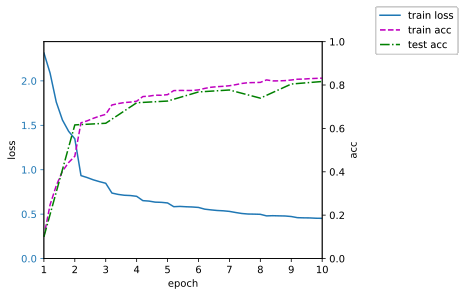

In [44]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, utils.try_gpu())

In [42]:
class Animator2:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=['loss', 'acc'], legend=None, xlim=None,
                 ylim=[0, None], xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(5, 4), color = ['#1f77b4', 'black']):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        self.legend = legend
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, self.axes.twinx()]
        # 使用lambda函数捕获参数
        self.config_axes_main = lambda: self.set_axes(
            self.axes[0], xlabel, ylabel[0], xlim, ylim, xscale, yscale, color[0])
        self.config_axes_sub = lambda: self.set_axes(
            self.axes[1], xlabel, ylabel[1], xlim, [0, 1], xscale, yscale, color[1])
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        self.axes[1].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            if '-' == fmt:
                self.axes[0].plot(x, y, fmt)
            else:
                self.axes[1].plot(x, y, fmt)
        self.config_axes_main()
        self.config_axes_sub()
        self.fig.legend(labels = self.legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        display.display(self.fig)
        display.clear_output(wait=True)
    
    def set_axes(self, axes, xlabel, ylabel, xlim, ylim, xscale, yscale, color):
        """Set the axes for matplotlib."""
        axes.set_xlabel(xlabel)
        axes.set_ylabel(ylabel)
        axes.set_xscale(xscale)
        axes.set_yscale(yscale)
        axes.set_xlim(xlim)
        axes.set_ylim(ylim)
        axes.tick_params(axis='y', color=color, labelcolor=color)